In [1]:
import tensorflow as tf
from keras import layers, Model
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from keras.callbacks import Callback
from keras.utils import array_to_img
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling1D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.reset_memory_stats(gpu, True)
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
month_name='JanFeb'
day_type = 'w'
my_data = pd.read_csv(f'ForGAN/{month_name}.csv')
ds = []
if day_type == 'w':
    for c in my_data.columns:
        if 'weekday' in c:
            ds.append([my_data[c].values])
else:
    for c in my_data.columns:
        if 'weekend' in c:
            ds.append([my_data[c].values])

max = np.max(ds)
ds = np.divide(ds, max)

### Prepare data to feed into GAN

In [14]:
ds = tf.data.Dataset.from_tensor_slices(ds)
batch_size = 12
ds = ds.cache()
ds = ds.shuffle(1000)
ds = ds.batch(batch_size)
ds = ds.prefetch(64)

## Generator Discriminator Training

In [10]:
g_relu = 0.2
if day_type == 'w':
    def build_generator():
        model = Sequential()

        model.add(Dense(1*96*batch_size, input_dim=batch_size))
        model.add(LeakyReLU(g_relu))
        model.add(Reshape((1,96, batch_size)))

        #model.add(UpSamplingD())
        model.add(Conv2D(batch_size, 3, padding='same'))
        model.add(LeakyReLU(g_relu))

        model.add(Conv2D(batch_size, 3, padding='same'))
        model.add(LeakyReLU(g_relu))

        model.add(Conv2D(batch_size, 3, padding='same'))
        model.add(LeakyReLU(g_relu))

        model.add(Conv2D(batch_size, 3, padding='same'))
        model.add(LeakyReLU(g_relu))


        model.add(Conv2D(1, 5, padding='same', activation='sigmoid'))
        return model
    generator = build_generator()
    generator.summary()
else:
    def build_generator():
            model = Sequential()

            model.add(Dense(1*96*batch_size, input_dim=batch_size))
            model.add(LeakyReLU(g_relu))
            model.add(Reshape((1,96, batch_size)))

            #model.add(UpSamplingD())
            model.add(Conv2D(batch_size, 5, padding='same'))
            model.add(LeakyReLU(g_relu))

            model.add(Conv2D(batch_size, 5, padding='same'))
            model.add(LeakyReLU(g_relu))

            model.add(Conv2D(batch_size, 5, padding='same'))
            model.add(LeakyReLU(g_relu))

            model.add(Conv2D(1, 5, padding='same', activation='sigmoid'))
            return model
generator = build_generator()



d_relu = 0.2
d_dropout = 0.2
if day_type == 'w':
    def build_discriminator():
        model = Sequential()

        model.add(Dense(200, input_shape=(1, 96, 1)))
        model.add(LeakyReLU(d_relu))
        model.add(Dropout(d_dropout))

        model.add(Dense(150))
        model.add(LeakyReLU(d_relu))
        model.add(Dropout(d_dropout))

        model.add(Flatten())
        model.add(Dropout(d_dropout))
        model.add(Dense(1, activation='sigmoid'))
        # 1: fake series, 0: real series

        return model
    discriminator = build_discriminator()
    discriminator.summary()
else:
    def build_discriminator():
            model = Sequential()

            model.add(Dense(100, input_shape=(1, 96, 1)))
            model.add(LeakyReLU(d_relu))
            model.add(Dropout(d_dropout))

            model.add(Dense(120))
            model.add(LeakyReLU(d_relu))
            model.add(Dropout(d_dropout))

            model.add(Flatten())
            model.add(Dropout(d_dropout))
            model.add(Dense(1, activation='sigmoid'))
            # 1: fake series, 0: real series

            return model
discriminator = build_discriminator()


g_a, d_a = 0.0001, 0.00001
g_opt = Adam(learning_rate=g_a)
d_opt = Adam(learning_rate=d_a)  # Does not learn too fast
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
class LoadGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compilee(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_series = batch
        fake_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images
            yhat_real = self.discriminator(real_series, training=True)
            yhat_fake = self.discriminator(fake_series, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake series
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)


            # pass through and add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Generator training
        with tf.GradientTape() as g_tape:
            # generate same new images
            gen_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_series, training=False)

            # calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
loadgan = LoadGAN(generator, discriminator)
loadgan.compilee(g_opt, d_opt, g_loss, d_loss)

#### Call Back

In [25]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=batch_size):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vector = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_series = self.model.generator(random_latent_vector)
        generated_series *= max
        generated_series.numpy()
        for i in range(self.num_img):
            serie = array_to_img(generated_series[i])


#### Train

In [11]:
hist = loadgan.fit(ds, epochs=500)

Epoch 1/500
20/20 [==============================] - 2s 96ms/step - d_loss: 0.6863 - g_loss: 0.7289
Epoch 2/500
20/20 [==============================] - 3s 126ms/step - d_loss: 0.6831 - g_loss: 0.7473
Epoch 3/500
20/20 [==============================] - 2s 91ms/step - d_loss: 0.6814 - g_loss: 0.7642
Epoch 4/500
20/20 [==============================] - 2s 109ms/step - d_loss: 0.6834 - g_loss: 0.7790
Epoch 5/500
20/20 [==============================] - 3s 128ms/step - d_loss: 0.6821 - g_loss: 0.7911
Epoch 6/500
20/20 [==============================] - 3s 128ms/step - d_loss: 0.6825 - g_loss: 0.7986
Epoch 7/500
20/20 [==============================] - 3s 125ms/step - d_loss: 0.6859 - g_loss: 0.7990
Epoch 8/500
20/20 [==============================] - 3s 130ms/step - d_loss: 0.6921 - g_loss: 0.7893
Epoch 9/500
20/20 [==============================] - 2s 113ms/step - d_loss: 0.6990 - g_loss: 0.7673
Epoch 10/500
20/20 [==============================] - 2s 101ms/step - d_loss: 0.7089 - g_loss

1/1 [==============================] - 0s 42ms/step


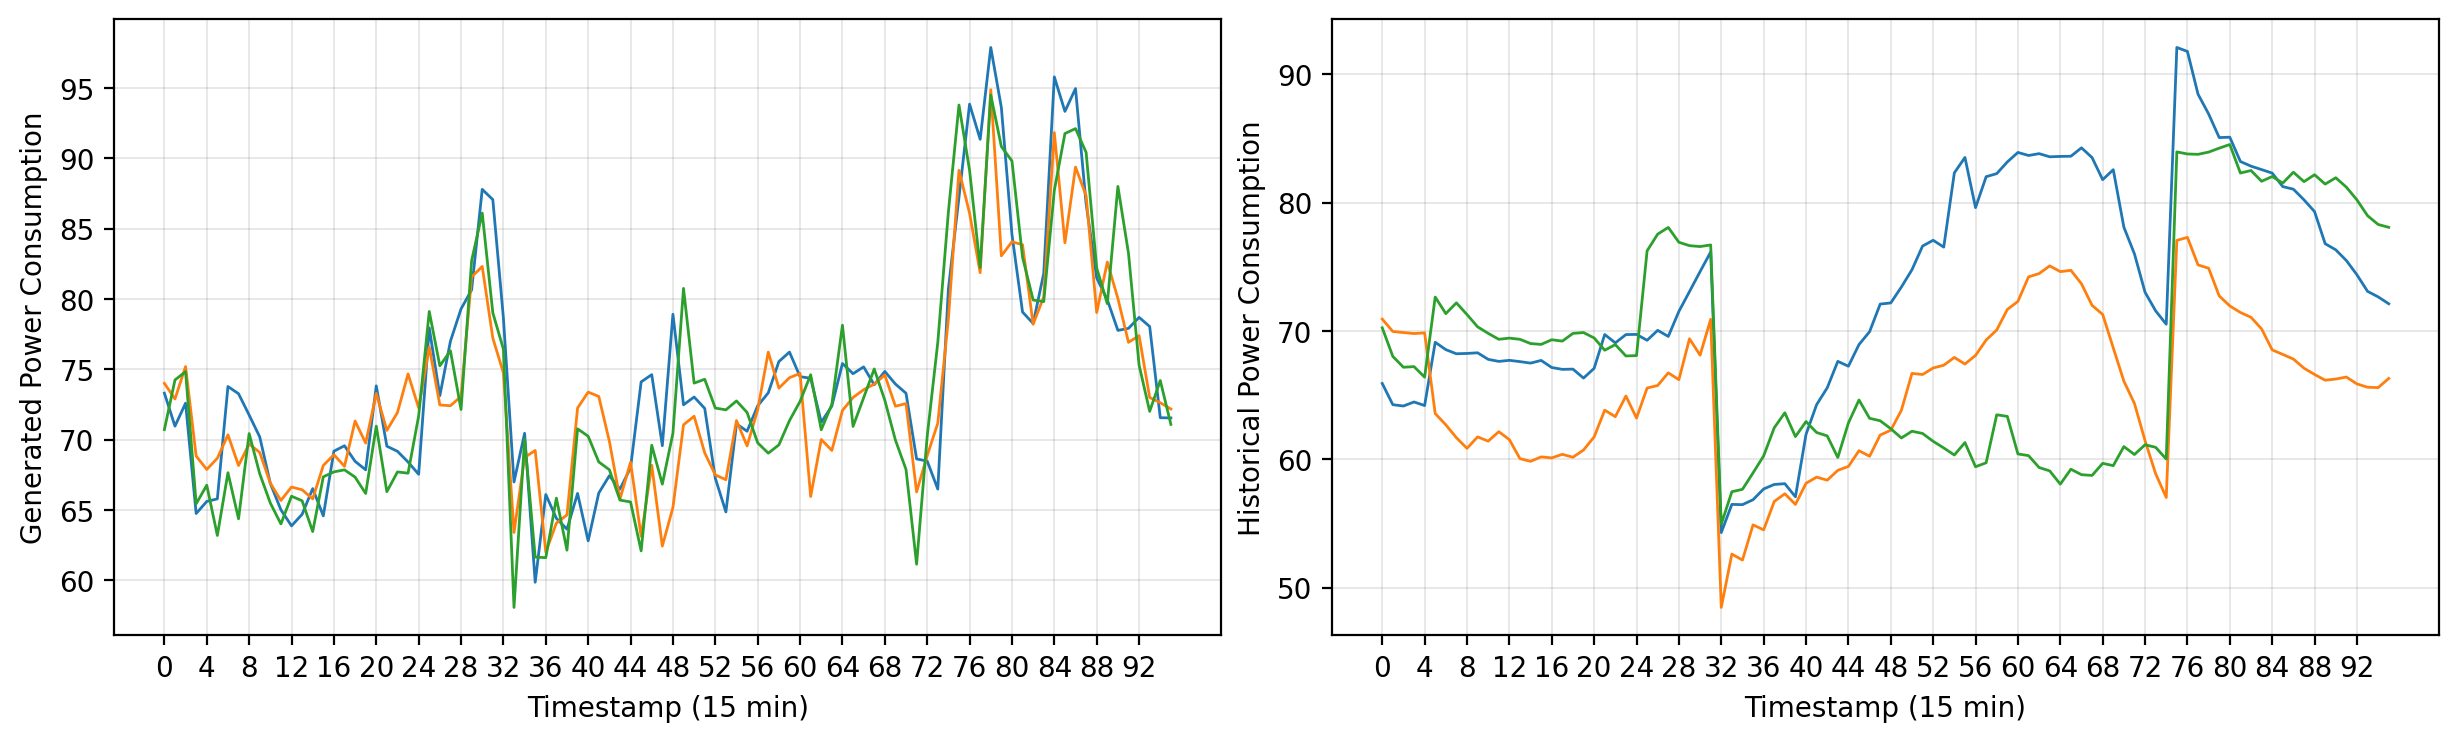

In [12]:
if True:
    scenario_size = 3
    normal_noise = tf.random.normal((scenario_size, batch_size, 1))
    n = [np.random.normal() for _ in range(scenario_size)]
    series = np.multiply(generator.predict(normal_noise), max)
    resolution = 96

    probabilities = []
    ranges = np.linspace(-3.5, 3.5, 8)
    intervals = np.linspace(-3, 3, 7)
    probs = [stats.norm.cdf(i) for i in n]
    prob_ranges = {intervals[i]: [stats.norm.cdf(ranges[i]), stats.norm.cdf(ranges[i+1])] for i in range(len(intervals))}
    for i in probs:
        for key in intervals:
            if prob_ranges[key][0]<= i <=prob_ranges[key][1]:
                probabilities.append(prob_ranges[key][1]-prob_ranges[key][0])
                break
    scenarios = {'probs': probabilities}
    for j in range(resolution):
        scenarios[j] = []
    for i in range(scenario_size):
        s = series[i].reshape([resolution])
        for j in range(resolution):
            scenarios[j].append(s[j])
pd.DataFrame(scenarios).to_csv(f'LoadScenarios-{month_name}-{day_type}.csv')
if True:
    ticks = [i for i in range(resolution) if i%4 == 0]
    fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
    for s in series[:3]:
        ax[0].plot(range(resolution), s.reshape([resolution]), linewidth=1)
    ax[0].set_xlabel('Timestamp (15 min)')
    ax[0].set_ylabel('Generated Power Consumption')
    ax[0].set_xticks(ticks, ticks)
    ax[0].grid(color='#666362', linestyle='-', linewidth=0.1)

    if day_type == 'w':
        ax[1].plot(my_data[[c for c in my_data.columns if 'weekday' in c][:3]], linewidth=1)
    else:
        ax[1].plot(my_data[[c for c in my_data.columns if 'weekend' in c][:3]], linewidth=1)
    ax[1].set_xlabel('Timestamp (15 min)')
    ax[1].set_ylabel('Historical Power Consumption')
    ax[1].set_xticks(ticks, ticks)
    ax[1].grid(color='#666362', linestyle='-', linewidth=0.1)
    plt.subplots_adjust(wspace=0.1)
# plt.savefig(f'IMG/{month_name}-{day_type}.jpg', bbox_inches='tight')

### Save models

In [22]:
generator.save(f'HarrisCounty/GAN Models/generator-{month_name}-{day_type}.h5')
discriminator.save(f'HarrisCounty/GAN Models/discriminator-{month_name}-{day_type}.h5')

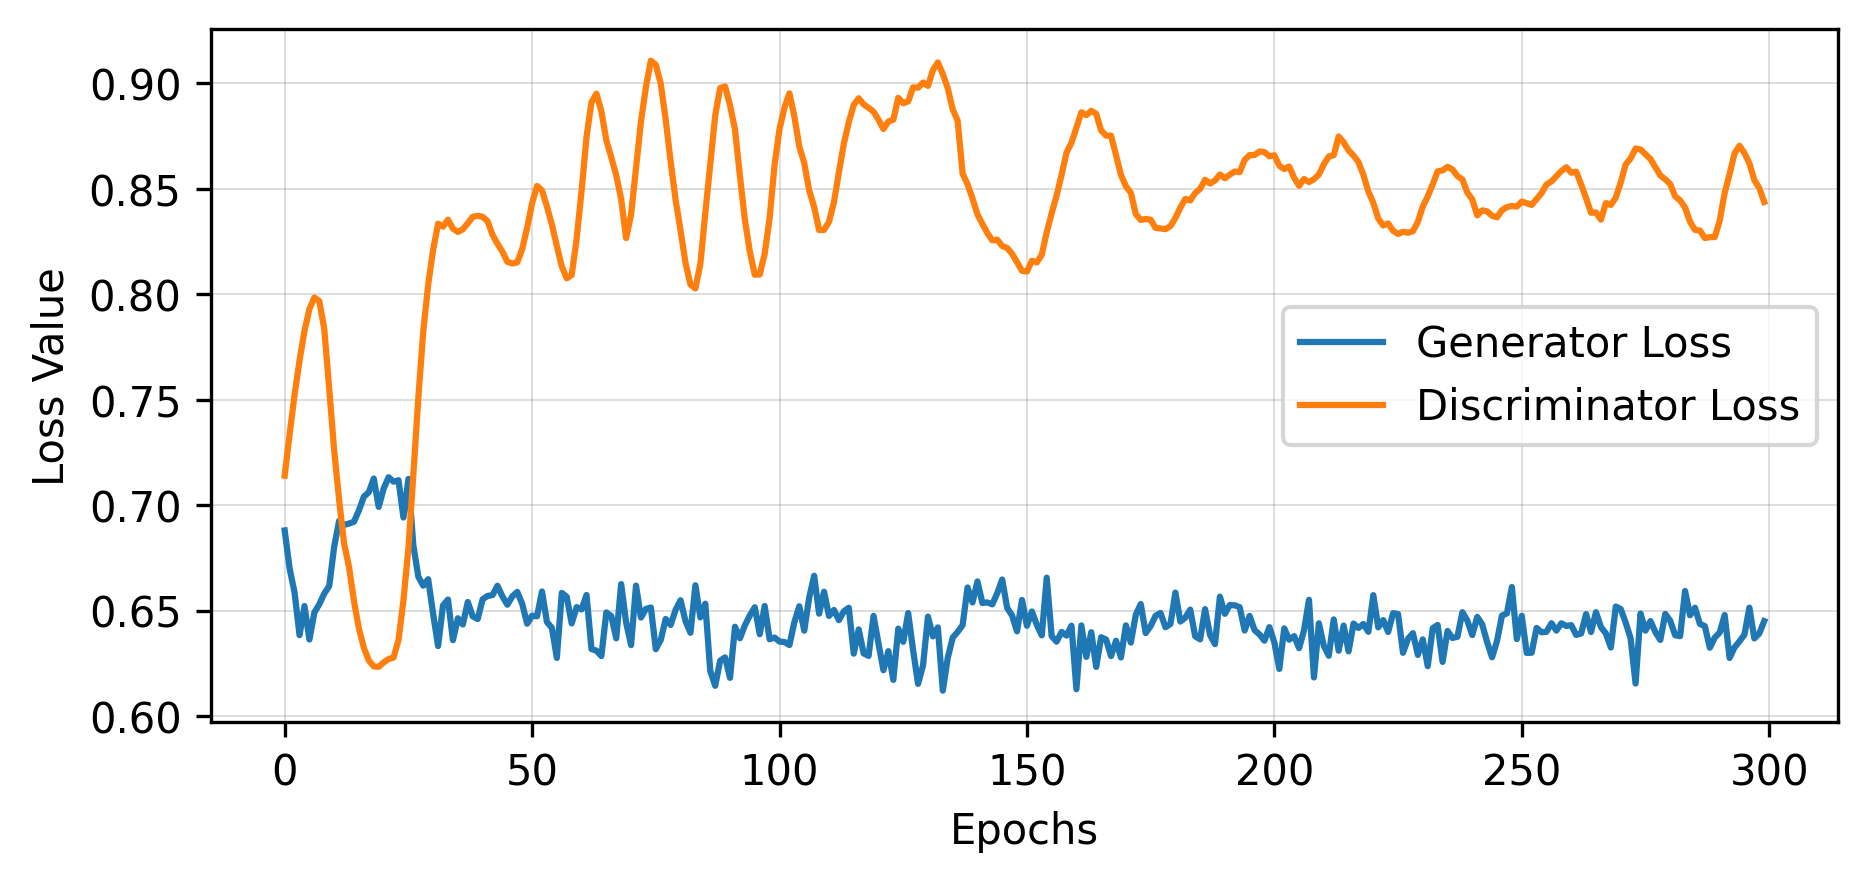

In [30]:
plt.figure(figsize=(7, 3), dpi=300)
plt.plot(hist.history['d_loss'], label='Generator Loss')
plt.plot(hist.history['g_loss'], label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(color='#666362', linestyle='-', linewidth=0.1)
plt.savefig(f'IMG/{month_name}-{day_type}-loss.jpg', bbox_inches='tight')